# Predicting Completion Time from Recipe Text


Is it possible to train a model to label recipes with an estimated completion time, given only the text of the instructions? Here we use a dataset of recipes from AllRecipes.com to train several scikit-learn models, including individual models and ensemble approaches.  
Video Link: https://youtu.be/JuV5kQvb6p8  
Supplementary Materials: https://drive.google.com/drive/folders/1mZScUxlgA2DvXRpll7rDYC-YYngHt14O?usp=share_link


In [103]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
datapath = '/content/drive/MyDrive/Colab Notebooks/Recipe ML Project/recipe_data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data
Please see the supplementary materials for code on data cleaning, which included using regular expressions to parse out the completion time from the recipe text.

In [104]:
df = pd.read_csv(datapath+'clean_recipe_data.csv')
print(df.shape)
df.head()

(44529, 11)


,Unnamed: 0,recipe_id,recipe_name,aver_rate,review_nums,ingredients,cooking_directions,ready_time_minutes,directions_text,direction_text_num_words,num_ingredients
0,0,222388,Homemade Bacon,5.000000,3,pork belly^smoked paprika^kosher salt^ground black pepper,{'directions': u'Prep\n5 m\nCook\n2 h 45 m\nReady In\n11 h 50 m\nPreheat oven to 200 degrees F (...,710.0,"Preheat oven to 200 degrees F (95 degrees C). Season pork belly with paprika, salt, and pepper. ...",106,4
1,1,240488,"Pork Loin, Apples, and Sauerkraut",4.764706,29,sauerkraut drained^Granny Smith apples sliced^large onion^caraway seeds^apple cider divided^brow...,{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nReady In\n2 h 45 m\nPreheat oven to 325 degrees F (...,165.0,"Preheat oven to 325 degrees F (165 degrees C). Mix sauerkraut, apples, onion, and caraway seeds ...",131,12
2,2,218939,Foolproof Rosemary Chicken Wings,4.571429,12,chicken wings^sprigs rosemary^head garlic^olive oil^lemon pepper^seasoned salt,"{'directions': u""Prep\n20 m\nCook\n40 m\nReady In\n1 h\nPreheat an oven to 350 degrees F (175 de...",60.0,"Preheat an oven to 350 degrees F (175 degrees C). Arrange the chicken wings, rosemary, and garli...",155,6
3,3,87211,Chicken Pesto Paninis,4.625000,163,focaccia bread quartered^prepared basil pesto^diced cooked chicken^diced green bell pepper^diced...,{'directions': u'Prep\n15 m\nCook\n5 m\nReady In\n20 m\nPreheat a panini grill.\nSlice each quar...,20.0,Preheat a panini grill. Slice each quarter of focaccia bread in half horizontally. Spread each h...,57,6
4,4,245714,Potato Bacon Pizza,4.500000,2,red potatoes^strips bacon^Sauce:^heavy whipping cream^butter^minced garlic^grated Parmesan chees...,{'directions': u'Prep\n20 m\nCook\n45 m\nReady In\n1 h 10 m\nPlace potato slices in a deep skill...,70.0,Place potato slices in a deep skillet and cover with 1 inch of water. Bring to a boil; reduce he...,255,14


## Remove outlier data points (cut off at 95th percentile)
Plotting the distribution of completion times, it's clear that the vast majority of recipes take less than an hour, but some list times as long as a month. It is not reasonable for a model to account for such bizarre outliers, so we choose to ignore data points with completion time beyond the 95th percentile and accept this as a limitation of our approach.  

The resulting distribution is much more even, with a long tail between 1 and 8 hours.

Text(0.5, 0, 'Recipe Time (minutes)')

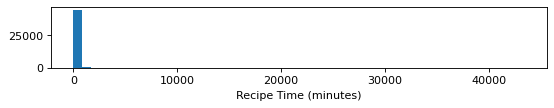

In [ ]:
counts, bins = np.histogram(df['ready_time_minutes'], bins=50)
plt.figure(figsize=(8, 1), dpi=80)
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel("Recipe Time (minutes)")

New Shape: (42312, 11)


Text(0.5, 0, 'Recipe Time (minutes)')

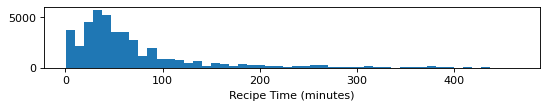

In [ ]:
percentile_95th = np.percentile(df['ready_time_minutes'], 95)
df = df[df['ready_time_minutes'] <= percentile_95th] # remove outlier recipes that take longer than 48 hours
print(f'New Shape: {df.shape}')
counts, bins = np.histogram(df['ready_time_minutes'], bins=50)
plt.figure(figsize=(8, 1), dpi=80)
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel("Recipe Time (minutes)")

In [ ]:
features_labels_df = df[['directions_text', 'ready_time_minutes']]
features_labels_df.head()

,directions_text,ready_time_minutes
1,"Preheat oven to 325 degrees F (165 degrees C). Mix sauerkraut, apples, onion, and caraway seeds in a large roasting pan. Stir 1/4 cup apple cider and brown sugar together in a separate bowl; pour over sauerkraut mixture. Stir Thai seasoning, salt, garlic powder, and black pepper together in a small bowl; rub onto the top and bottom of the roast. Make an indentation in the center of the sauerkr...",165.0
2,"Preheat an oven to 350 degrees F (175 degrees C). Arrange the chicken wings, rosemary, and garlic cloves on a broiler-proof baking sheet, making sure the chicken pieces are not touching. Drizzle the olive oil over the chicken and garlic. Season the wings on all sides with the lemon pepper and seasoned salt. Bake in the preheated oven until chicken meat is no longer pink at the bone and the jui...",60.0
3,"Preheat a panini grill. Slice each quarter of focaccia bread in half horizontally. Spread each half with pesto. Layer bottom halves with equal amounts chicken, bell pepper, onion, and cheese. Top with remaining focaccia halves, forming 4 sandwiches. Grill paninis 5 minutes in the preheated grill, or until focaccia bread is golden brown and cheese is melted.'}",20.0
4,"Place potato slices in a deep skillet and cover with 1 inch of water. Bring to a boil; reduce heat and simmer until just tender, about 5 minutes. Drain; set aside to cool. Place bacon slices in a large skillet and cook over medium-high heat, turning occasionally, until evenly browned, about 10 minutes. Drain bacon slices on paper towels; set aside to cool. Heat cream, butter, and garlic togeth...",70.0
6,"Heat medium skillet over medium heat. Butter bread on one side. Place one slice of bread, buttered side down, in skillet. Layer corned beef, sauerkraut and mozzarella on bread. Top with remaining slice of bread. Cook, turning once, until bread is browned, sandwich is heated through and cheese is melted. Serve immediately.'}",5.0


# Vectorize and Train-Test Split
To train a model, we somehow have to convert a recipe's text into numeric features. For this we choose to use raw word counts as features.  

We adjusted a parameter called "minimum document frequency" or "min_df" such that only words that appear in 5 or more recipes are used as features. This helpfully cuts the total number of features in half, from 8,000+ to 4298, by removing some textual artifacts, typos, and rare words that are not useful for generalizing.  

We considered also counting "n-grams," which are combinations of multiple words. We observed a small increase in performance, but the number of features exploded past 250,000 using only 1- and 2-grams, which became too computationally expensive, so we leave this as exploration for future work.  

The result is that each recipe is now represented by a vector of word counts, which can be used to train our models.  
 
We use 2/3 of the data for training and 1/3 for testing.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# make all the text lowercase
features_labels_df['directions_text'] = features_labels_df['directions_text'].str.lower()

vectorizer = CountVectorizer(ngram_range=(1,1), min_df=5)
X = vectorizer.fit_transform(features_labels_df['directions_text'])
y = features_labels_df['ready_time_minutes']

print('X:', X.shape, 'y:', y.shape)
vectorizer.get_feature_names_out()

X: (42312, 4298) y: (42312,)


array(['10', '100', '105', ..., 'zoodles', 'zucchini', 'zucchinis'],
      dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (28349, 4298) Test: (13963, 4298)


## Models
As a baseline, we start with some out-of-the box regression models, first KNN, Linear Regression, and then Decision Trees. We use R-squared as our score, a value between 0 and 1 where 1 means the regression model perfectly fits the data.   
  
**KNeighborsRegressor** performed poorly, with an R<sup>2</sup> score of 0.33.  
**LinearRegression** achieved an R<sup>2</sup> score of 0.658.    
And **DecisionTreeRegressor** achieved an R<sup>2</sup> score of 0.563.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=10).fit(X_train, y_train)
neigh.score(X_test, y_test) # 0.33

0.3338496078398492

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test) # 0.65

0.6585732727757954

In [ ]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor().fit(X_train, y_train)
reg.score(X_test, y_test) # 0.55

0.5633692673574984

Since the Decision Tree model shows promise and has some tunable parameters, we apply Grid Search and 5-fold Cross Validation to find more optimal parameters. Please see the supplementary materials for the complete Grid Search results. 

After tuning the *'max_depth'*, *'min_samples_split'*, and *'min_samples_leaf'* parameters, our DecisionTreeRegressor improves greatly, reaching an R<sup>2</sup> of 0.718.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth': [3, 7, 8, 9, 25, 50, 75, 100, 200],  'min_samples_split': [2, 0.1, 0.01, 0.005], 'min_samples_leaf': [0.0014, 0.0017, 0.002, 0.003, 0.005, 0.01]} 
reg = GridSearchCV(DecisionTreeRegressor(), parameters, cv=5) # 5-fold cross-validation
reg.fit(X_train, y_train)
print(reg.score(X_test, y_test))

gridsearch_results = pd.DataFrame(reg.cv_results_)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']]
gridsearch_results

Best params score: 0.7188613393072291

In [ ]:
# best: {'max_depth': 25, 'min_samples_leaf': 0.002, 'min_samples_split': 0.01}
reg.best_params_

## Ensembles
We now try two ensemble models: Random Forest Regressor and Gradient Boosting Tree. These models can take a long time to fit, especially with cross validation, so using grid search was less feasible here, and instead we borrow the tuned Decision Tree parameters from above.  

The RandomForestRegressor achieved an R<sup>2</sup> score of 0.729.  
The GradientBoostingRegressor reached an R<sup>2</sup> score of 0.767 - our highest score yet.




In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_parameters = {'max_depth': [25], 'min_samples_leaf': [0.002], 'min_samples_split': [0.01], 'n_estimators': [5, 10, 25, 50, 100]}
rf = GridSearchCV(RandomForestRegressor(), rf_parameters, cv=5) # 5-fold cross-validation
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7290317477446522

On the best parameters, RandomForestRegressor achieved score of 0.729.

In [ ]:
# best: {'max_depth': 25, 'min_samples_leaf': 0.002, 'min_samples_split': 0.01, 'n_estimators': 100} although the gains are minimal after 10
rf.best_params_

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_parameters = {'max_depth': [25], 'min_samples_leaf': [0.002], 'min_samples_split': [0.01], 'n_estimators': [5, 10, 25, 50, 100]}
gb = GridSearchCV(GradientBoostingRegressor(), gb_parameters, cv=3) # 3-fold cross-validation (5 takes too long)
gb.fit(X_train, y_train)
gb.score(X_test, y_test)

On the best parameters, GradientBoostingRegressor achieved score of 0.767.

In [ ]:
# best: {'max_depth': 25, 'min_samples_leaf': 0.002, 'min_samples_split': 0.01, 'n_estimators': 100} => 0.770
gb.best_params_

## Examples
Let's try our best model (GradientBoostingRegressor) on some real examples:

In [ ]:
# Fit our best model, (GradientBoostingRegressor) and predict using recipes from outside the dataset
from sklearn.ensemble import GradientBoostingRegressor
best_model = GradientBoostingRegressor(max_depth=25, min_samples_leaf=0.002, min_samples_split=0.01, n_estimators=100)
best_model.fit(X_train, y_train)
print('SCORE:', best_model.score(X_test, y_test))         

SCORE: 0.7675828803442392


Eggs Bennedict: 35 min  
Source: https://tastesbetterfromscratch.com/eggs-benedict-with-homemade-hollandaise-sauce/

In [ ]:
input_recipe = [
    """
Melt the butter in a small saucepan. In a separate small bowl, beat the egg yolks. Mix in lemon juice, whipping cream, and salt and pepper. 
Add a small spoonful of the hot melted butter to the egg mixture and stir well. Repeat this process adding a spoonful at a time of hot butter to the egg mixture.( Adding the butter slowly, a spoonful at a time, will temper the eggs and ensure they don't curdle). 
Once the butter has been incorporated, pour the mixture back into the saucepan. Cook on low heat, stirring constantly, for just 20-30 seconds. Remove from heat and set aside. It will thicken as it cools. Stir well and add another splash of cream, if needed, to thin. 
Fill a medium size pot with about 3 inches of water. Bring the water to a boil and then reduce heat until it reaches a simmer. You should see small bubbles coming to the surface but not rolling. 
Add a little splash of vinegar to the water (this is optional, but it helps the egg white to stay together once it is in the water). 
Crack one egg into a small cup (I use a measuring cup).  Lower the egg into the simmer water, gently easing it out of the cup. 
Cook the egg in simmering water for 3-5 minutes, depending on how soft you want your egg yolk. Remove the poached egg with a slotted spoon. 
**It is not abnormal for a white foam to form on top of the water when poaching an egg. You can simple skim the foam off of the water with a spoon. 
While the egg is cooking, place the slices of Canadian bacon in a large pan and cook on medium-high heat for about 1 minute on each side. 
Toast the English muffin. Top each toasted side with a slice or two of Canadian bacon, and then a poached egg. Top with hollandaise sauce. 
""".lower().replace('\n', '')
]

recipe_X = vectorizer.transform(input_recipe)
predicted_mintues = best_model.predict(recipe_X)[0]
print(f'Predicted: {predicted_mintues.round(2)} min, Actual: {35} min')

Predicted: 38.91 min, Actual: 35 min


Homemade Bread: 2h 30m (150m)  
Source: https://butterwithasideofbread.com/homemade-bread/

In [ ]:
input_recipe = [
    """In a large bowl, dissolve the 1 TBSP of the sugar in warm water and then stir in yeast. Allow to proof until yeast resembles a creamy foam, about 5 minutes. 
Mix remaining sugar, salt and oil into the yeast. Mix in flour one cup at a time. Dough should be tacky and clean the sides of the bowl save for a small part at the bottom. Too much flour added in yields a dry loaf of bread, so if you're worried you added too much, add a bit more hot water, until you get the correct consistency. 
Knead dough for 7 minutes. Place in a well oiled bowl, and turn dough to coat. Cover with a damp cloth. Allow to rise until doubled in bulk, about 1 hour. 
Punch dough down. Knead for 1 minute and divide in half. Shape into loaves and place into two greased 9×5 inch loaf pans. Allow to rise for 30 minutes, or until dough has risen 1 inch above pans. 
Bake at 350 degrees F (175 degrees C) for 30-40 minutes. Cool, brush with butter and enjoy!
""".lower().replace('\n', '')
]

recipe_X = vectorizer.transform(input_recipe)
predicted_mintues = best_model.predict(recipe_X)[0]
print(f'Predicted: {predicted_mintues.round(2)} min, Actual: {150} min')

Predicted: 156.02 min, Actual: 150 min


## Conclusion
It's exciting to see that the model can actually perform well on new recipes. In the examples above, a recipe for Eggs Bennedict is provided, from a website not included in the original dataset, and the model predicts a total time of 38.9 minutes - close to the actual time of 35 minutes. Providing a 150 minute recipe for homemade bread, the model predicts 156.0 mintues. 
  
The best model we trained was the **Gradient-Boosting Regressor**, which achieved an R<sup>2</sup> score of **0.767**. As expected, the ensemble methods performed better than the individual models, even with less parameter tuning (due to prohibitively long compute times). While not perfect, such a model could be useful on a site like AllRecipes.com, where lots of user-submitted recipes of varying quality are processed every day.